In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from pickle import load as pload
from json import load as load_json

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # for importing local packages from src

In [2]:
INPUT_VARIABLES = ['Tac', 'hs', 'u', 'Rg']
OUTPUT_VARIABLES = ['An', 'E', 'Rg', 'Tleaf']
STATE_VARIABLES = ['An', 'Ei', 'u', 'Tlc', 'Flux', 'Eabs', 'gs', 'E', 'gb', 'psi_head', 'FluxC']

In [3]:
EXPERIMENT_ROOT = '/media/mcndt/thesis/thesis-cyborg-plants/results/gdc_can1_6days_3runs/'
# EXPERIMENT_ROOT = 'F:/thesis-cyborg-plants/results/gdc_can1_6days_3runs'

## Creating utility classes for handling experiment data

In [4]:
from src.model.reservoir_state import ReservoirState
from src.model.hydroshoot_experiment import load_runs

## Loading all the experiment data

In [5]:
# Source: personal python snippet library
def get_dirs_in_directory(path):
    """get all subdirectories in the given path (non-recursive)."""
    dirs = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        dirs.extend([f for f in dirnames])
        break  # only explore top level directory
    return dirs

In [6]:
# Loading all the data
runs = load_runs(EXPERIMENT_ROOT)
print(runs)

[HydroShootExperiment(n_steps=144, state_size=360), HydroShootExperiment(n_steps=144, state_size=360), HydroShootExperiment(n_steps=144, state_size=360)]


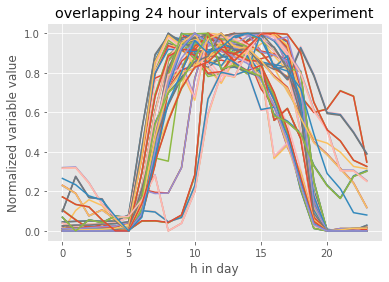

In [7]:
with plt.style.context('ggplot'):

  for run in runs:
    for key in OUTPUT_VARIABLES:
      target = run.get_target(key, scope='outputs')
      for i in range(run.n_steps() // 24):
        j = i * 24
        plt.plot((target[j:j+24] - target[j:j+24].min()) / (target[j:j+24].max() - target[j:j+24].min()))

  plt.title('overlapping 24 hour intervals of experiment')
  plt.xlabel('h in day')
  plt.ylabel('Normalized variable value')
  plt.show()

## Training a cross-validated, regularized readout function

In [8]:
TARGET = 'Rg'      # Absorbed shortwave irradiance by whole plant
TARGET_SCOPE = 'outputs'
STATE_VAR = 'E'  # Leaf temperature

STATE_SIZE = 32
SAMPLES_PER_RUN = 8
WARMUP_STEPS = 24  # ignore the first N steps as a model warmup

DEFAULT_REGULIZATION = 1.0

### Prepare dataset for training

In [9]:
def generate_mask(h_start, h_end, length=24):
  """Generates a 1D bitmask of size 24 whether to include a sample or not.
  Datum are included if h_start <= time < h_end
  """
  return np.array([h_start <= i < h_end for i in range(length)], dtype=bool)

mask = generate_mask(5, 21)

In [10]:
# def prepare_data(runs, state_var, target, target_scope=None, state_size=32, samples_per_run=1, warmup_steps=0, mask=None, mask_length=24):
#   """Returns (X, y, groups) for the given state variable and target.
  
#   state_size (int): the amount of leaves to randomly sample. Default is 32.
#   samples_per_run (int): The amount of samples to draw from the total state. Samples will not overlap. Default is 1.
#   warmup_steps (int): The amount of time steps to discard as simulation warmup time. Default is 0.

#   Assumes that every run has the same state size.
#   """
#   if runs[0].state_size() < state_size * samples_per_run:
#     raise ValueError(f'Cannot draw {samples_per_run} samples of size {state_size} from an experiment of total state size {runs[0].state_size()}.')

#   if mask is None:
#     mask = np.ones(mask_length, dtype=bool)

#   _X = []
#   _y = []
#   _groups = []

#   for i_group, run in enumerate(runs):
#     # generate mask of same length as run
#     run_mask = np.ones(run.n_steps(), dtype=bool)
#     run_mask[:WARMUP_STEPS] = False
#     n_cycles = run.n_steps() // mask_length
#     for c in range(n_cycles):
#       c_ = c * mask_length
#       run_mask[c_:c_+mask_length] &= mask

#     # generate random sample of available leaves to observe
#     state_samples = np.random.choice(run.state_size(), size=(samples_per_run, state_size), replace=False)
#     state_data = run.states[STATE_VAR]
    
#     # get X, y and group data
#     for i_sample in range(samples_per_run):
#       row_idx = state_samples[i_sample,:]
#       X_i = state_data[run_mask][:, row_idx]
#       y_i = run.get_target(target, scope=target_scope)[run_mask]
#       g_i = np.ones(len(X_i)) * i_group

#       _X.append(X_i)
#       _y.append(y_i)
#       _groups.append(g_i)

#   # Concatenate all series for use in sklearn
#   X = np.concatenate(_X, axis=0)
#   y = np.concatenate(_y, axis=0)
#   groups = np.concatenate(_groups, axis=0)
  
#   return X, y, groups

In [40]:
def preprocess_data(runs, state_var, target, target_scope=None, state_size=32, samples_per_run=1, warmup_steps=0, mask=None, mask_length=24):
  """X, y ndarrays of given data.

  X: ndarray of shape (run, state_sample, day, step, variable)
  y: ndarray of shape (run, state_sample, day, step)
  - The run index means all data came from the same simulation run.
  - The state_sample indicates which leaves were observed.
  
  state_size (int): the amount of leaves to randomly sample. Default is 32.
  samples_per_run (int): The amount of samples to draw from the total state. Samples will not overlap. Default is 1.
  warmup_steps (int): The amount of time steps to discard as simulation warmup time. Default is 0.

  Assumes that every run has the same state size.
  """
  if runs[0].state_size() < state_size * samples_per_run:
    raise ValueError(f'Cannot draw {samples_per_run} samples of size {state_size} from an experiment of total state size {runs[0].state_size()}.')

  if (warmup_steps % 24) != 0:
    raise ValueError(f'Only warmup steps of integer days (0, 24, 48, ...) are currently supported.')

  if mask is None:
    mask = np.ones(mask_length, dtype=bool)

  # 1. Aggregate data from each experiment run (and each sample within the run, if samples_per_run > 1)
  data = []  # insert tuples of (state, target, group)
  
  for i_group, run in enumerate(runs):
    # generate random sample of available leaves to observe
    state_samples = np.random.choice(run.state_size(), size=(samples_per_run, state_size), replace=False)
    state_data = run.states[STATE_VAR]
    y_i = run.get_target(target, scope=target_scope)

    for i_sample in range(samples_per_run):
      row_idx = state_samples[i_sample,:]
      X_i = state_data[:, row_idx]
      data.append((X_i, y_i, i_group))

  # 2. Remove sample points using warmup mask and cyclic mask
  for i, (Xi, yi, gi) in enumerate(data): 
    run_mask = np.ones(len(Xi), dtype=bool)
    run_mask[:WARMUP_STEPS] = False           # warmup mask
    run_mask &= np.tile(mask, len(Xi) // mask_length)  # cyclical mask
    data[i] = Xi[run_mask], yi[run_mask], gi

  # 3. Shape data into ndarray of shape (group, sample, day, step, variable)
  # TODO: make this work with masks that are not an integer amount of days!
  
  samples_per_day = mask.sum(dtype=int)
  assert(len(data[0][0]) % samples_per_day == 0)
  n_days = len(data[0][0]) // samples_per_day

  X = np.empty((len(runs), samples_per_run, n_days, samples_per_day, state_size))
  y = np.empty((len(runs), samples_per_run, n_days, samples_per_day))

  i_sample, current_group = None, None
  for Xi, yi, gi in data:
    if gi != current_group:
      i_sample, current_group = 0, gi
    Xi = Xi.reshape((n_days, samples_per_day, state_size))
    yi = yi.reshape((n_days, samples_per_day))
    X[current_group, i_sample] = Xi
    y[current_group, i_sample] = yi
    i_sample += 1

  # 4. Normalize X by scaling per variable dimension.
  X_mean = X.mean(axis=(0, 1, 2, 3))
  X_std = X.std(axis=(0, 1, 2, 3))
  X = (X - X_mean) / X_std

  return X, y

X, y = preprocess_data(runs, STATE_VAR, TARGET, 
    target_scope=TARGET_SCOPE,
    state_size=STATE_SIZE, 
    samples_per_run=SAMPLES_PER_RUN, 
    warmup_steps=WARMUP_STEPS,
    mask=generate_mask(5, 21))

print(generate_mask(5, 21).sum())
print(X.shape, y.shape)

16
(3, 8, 5, 16, 32) (3, 8, 5, 16)


In [43]:
def alternating_groups(X, n_groups=2) -> np.ndarray:
  """Generates a group index array of X where the group ids alternate
  from sample day to sample day (as in Pieters et al. 2021).

  This avoids correlation between adjacent days from introducing bias during training."""
  n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape
  n_data_samples = n_runs * n_state_samples * n_days
  groups = np.empty((n_data_samples), dtype=int)
  for i in range(n_groups):
    groups[i::n_groups] = i
  return groups.repeat(n_steps)

print(alternating_groups(X, 3)[:49])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0]


In [44]:
from typing import Tuple

def reshape_data(X, y) -> Tuple[np.ndarray, np.ndarray]:
  """Reshapes preprocessed data into 2D matrices for model training."""
  n_runs, n_state_samples, n_days, n_steps, n_variables = X.shape
  X = X.reshape((n_runs * n_state_samples * n_days * n_steps, n_variables))
  y = y.reshape((n_runs * n_state_samples * n_days * n_steps))
  return X, y

_X, _y = reshape_data(X, y)

print(_X.shape, _y.shape)


(1920, 32) (1920,)


In [84]:
X_raw, y_raw = preprocess_data(runs, STATE_VAR, TARGET, 
    target_scope=TARGET_SCOPE,
    state_size=64, 
    samples_per_run=1, 
    warmup_steps=WARMUP_STEPS,
    mask=generate_mask(5, 21))

# X_raw, y_raw = preprocess_data(runs, STATE_VAR, TARGET, 
#     target_scope=TARGET_SCOPE,
#     state_size=STATE_SIZE, 
#     samples_per_run=SAMPLES_PER_RUN, 
#     warmup_steps=WARMUP_STEPS,
#     mask=generate_mask(5, 21))

groups = alternating_groups(X_raw, 2)
X, y = reshape_data(X_raw, y_raw)
print(X.shape, y.shape, groups.shape)



(240, 64) (240,) (240,)


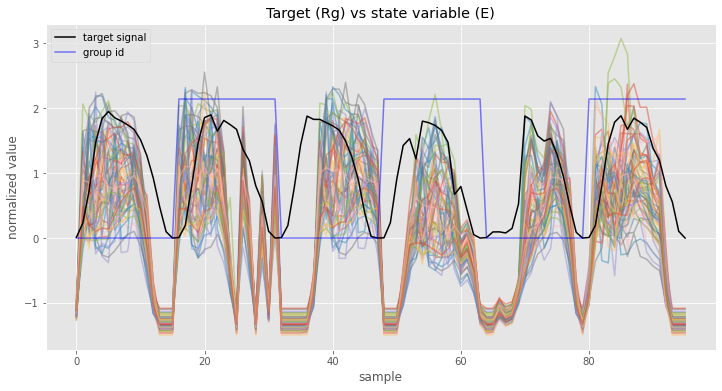

In [85]:
size = 16

with plt.style.context('ggplot'):
  plt.figure(figsize=(12, 6))
  plt.plot(X[:6 * size], alpha=0.5)
  plt.plot(y[:6 * size] / y.mean(), c='black', label='target signal')
  plt.plot(groups[:6 * size] / groups.mean(), c='blue', alpha=0.5, label="group id")
  plt.title(f'Target ({TARGET}) vs state variable ({STATE_VAR})')
  plt.xlabel('sample')
  plt.ylabel('normalized value')
  plt.legend()
  plt.show()

### Creating training-validation folds

In [86]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut

# folds = GroupKFold(n_splits=3)
folds = LeaveOneGroupOut()

### Determining the model score

In [87]:
from util import print_cv_scores, print_search_scores, print_search_best_params

from src.learning.scorers import nmse_scorer


In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

readout = Pipeline([
    ('ridge_regression', Ridge(alpha=DEFAULT_REGULIZATION, fit_intercept=True))
])

cv_scores = cross_validate(readout, X, y, 
    groups=groups, 
    cv=folds, 
    scoring=nmse_scorer, 
    return_train_score=True, 
    n_jobs=-1, 
    verbose=False)

print('--- Untuned score ---')
print_cv_scores(cv_scores)

--- Untuned score ---

+-------- FIT STATISTICS --------+
	Training score =         -0.4587 +/- 0.03977
	Cross-validation score = -0.8387 +/- 0.08908


In [89]:
search_grid = [{
  'ridge_regression__alpha': 10 ** np.linspace(np.log10(1e-4), np.log10(1e6), 500)

}]

grid_search = GridSearchCV(readout, 
  param_grid=search_grid, 
  cv=folds, 
  scoring=nmse_scorer, 
  n_jobs=-1, 
  verbose=False, 
  return_train_score=True
  )

grid_search.fit(X, y, groups=groups)

print('\n\n--- Tuned hyperparemeters ---')
print_search_best_params(grid_search)
print_search_scores(grid_search)



--- Tuned hyperparemeters ---

+----- OPTIMAL HYPERPARAMS ------+
	ridge_regression__alpha = 35.571502068213825

+-------- FIT STATISTICS --------+
	Training score =         -0.5876 +/- 0.00630
	Cross-validation score = -0.7003 +/- 0.03907


In [90]:
readout = Ridge(alpha=DEFAULT_REGULIZATION, fit_intercept=True, solver='cholesky') 
readout.fit(X, y)


Ridge(solver='cholesky')

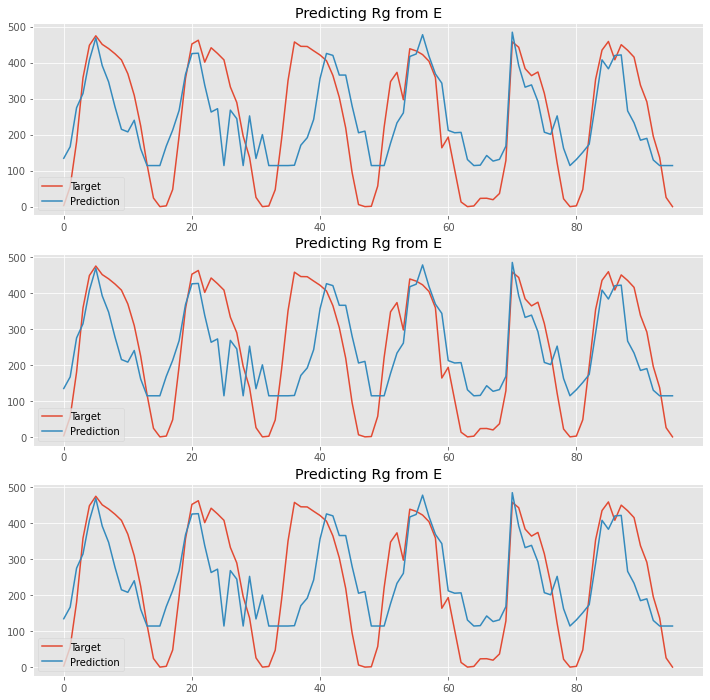

In [91]:
# visualize fit

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(3, 1, figsize=(12, 12))

  for i, run in enumerate(runs):
    # state_idx = np.random.choice(run.state_size(), STATE_SIZE, replace=False)
    X_ = X[:16 * 6] # run.states[STATE_VAR][WARMUP_STEPS:, state_idx]

    target = y[:16 * 6] # run.outputs[TARGET][WARMUP_STEPS:].to_numpy()
    y_pred = readout.predict(X_)

    ax[i].plot(target, label='Target')
    ax[i].plot(y_pred, label='Prediction')
    ax[i].set_title(f'Predicting {TARGET} from {STATE_VAR}')
    ax[i].legend()

  plt.show()